In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [2]:
import time

In [3]:
data_root = '/kaggle/input/chest-xray-pneumonia/chest_xray'

In [4]:
batch_size = 32
num_epochs = 10
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [6]:
train_ds = datasets.ImageFolder(f"{data_root}/train", transform)
test_ds = datasets.ImageFolder(f"{data_root}/test", transform)

In [7]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [8]:
model = models.googlenet(weights="IMAGENET1K_V1")      # torchvision ≥0.13
model.fc = nn.Linear(1024, 1)                          # binary logit output
model = model.to(device)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 165MB/s] 


In [10]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start = time.time()
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        logits = model(imgs)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}  |  loss: {running_loss/len(train_loader):.4f}")
    print('Time taken: ', time.time()-start)

Epoch 1/10  |  loss: 0.1424
Time taken:  117.8020806312561
Epoch 2/10  |  loss: 0.0347
Time taken:  89.22153973579407
Epoch 3/10  |  loss: 0.0213
Time taken:  87.6366319656372
Epoch 4/10  |  loss: 0.0121
Time taken:  86.8297221660614
Epoch 5/10  |  loss: 0.0079
Time taken:  86.09469509124756
Epoch 6/10  |  loss: 0.0064
Time taken:  85.00056600570679
Epoch 7/10  |  loss: 0.0082
Time taken:  84.8398699760437
Epoch 8/10  |  loss: 0.0098
Time taken:  84.38233637809753
Epoch 9/10  |  loss: 0.0040
Time taken:  86.09006595611572
Epoch 10/10  |  loss: 0.0050
Time taken:  84.45845890045166


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [13]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Binarize predictions with threshold 0.5
all_preds_bin = [1 if p >= 0.5 else 0 for p in all_preds]

# Metrics
accuracy = accuracy_score(all_labels, all_preds_bin)
precision = precision_score(all_labels, all_preds_bin)
recall = recall_score(all_labels, all_preds_bin)
f1 = f1_score(all_labels, all_preds_bin)
roc_auc = roc_auc_score(all_labels, all_preds)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

Accuracy:  0.7869
Precision: 0.7476
Recall:    0.9949
F1 Score:  0.8537
ROC-AUC:   0.9220


In [14]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

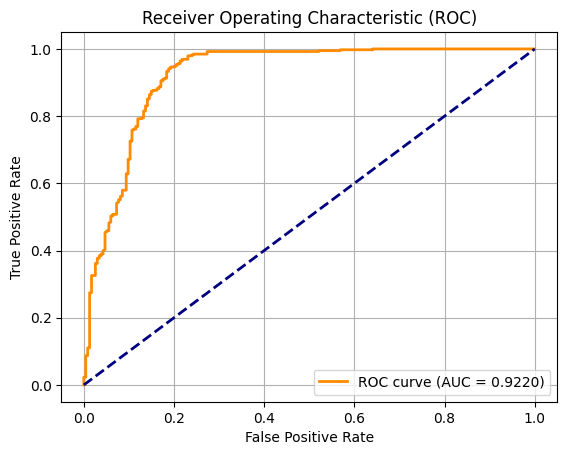

In [15]:
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()